После того, как мы научились аппроксимировать q-функцию на бескрайних просторах пространства состояний, можно подумать о том, как было бы неплохо уметь накапливать собственный опыт об окружающем мире. В этом уроке мы воспользуемся очень простым, но мощным инструментом - буфером воспроизведения опыта.

Идея проста: в течение эпизода запоминать шаги в собственной памяти агента, после того, как опыт будет накоплен, агент начинает сэмплировать его и обучать функцию ценности. Такой механизм снизит скоррелированность действий и повысит устойчивость обучения.

In [1]:
import gym
import torch
from torch.autograd import Variable
from collections import deque
import random
import math

In [2]:
class Estimator():
    def __init__(self, n_feat, n_state, n_action, lr=0.05):
        self.w, self.b = self.get_gaussian_wb(n_feat, n_state)
        self.n_feat = n_feat
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()

        for _ in range(n_action):
            model = torch.nn.Linear(n_feat, 1)
            self.models.append(model)
            optimizer = torch.optim.SGD(model.parameters(), lr)
            self.optimizers.append(optimizer)


    def get_gaussian_wb(self, n_feat, n_state, sigma=.2):
        """
        Generate the coefficients of the feature set from Gaussian distribution
        @param n_feat: number of features
        @param n_state: number of states
        @param sigma: kernel parameter
        @return: coefficients of the features
        """
        torch.manual_seed(0)
        w = torch.randn((n_state, n_feat)) * 1.0 / sigma        
        b = torch.rand(n_feat) * 2.0 * math.pi
        return w, b

    def get_feature(self, s):
        """
        Generate features based on the input state
        @param s: input state
        @return: features
        """
        features = (2.0 / self.n_feat) ** .5 * torch.cos(
            torch.matmul(torch.tensor(s).float(), self.w) + self.b)
        return features


    def update(self, s, a, y):
        """
        Update the weights for the linear estimator with the given training sample
        @param s: state
        @param a: action
        @param y: target value
        """
        features = Variable(self.get_feature(s))
        y_pred = self.models[a](features)

        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))

        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()

    def predict(self, s):
        """
        Compute the Q values of the state using the learning model
        @param s: input state
        @return: Q values of the state
        """
        features = self.get_feature(s)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])

In [3]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        probs = torch.ones(n_action) * epsilon / n_action
        q_values = estimator.predict(state)
        best_action = torch.argmax(q_values).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function


Функция Q-обучения выполняет много задач: 

1. создает жадную поведенческую стратегию 
2. выполняет эпизод и сохраняет информацию об этом в память агента
3. после окончания эпизода семплирует данные из памяти и обновляет веса функции ценности 

In [4]:
def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Q-Learning algorithm using Function Approximation, with experience replay
    @param env: Gym environment
    @param estimator: Estimator object
    @param replay_size: number of samples we use to update the model each time
    @param n_episode: number of episodes
    @param gamma: the discount factor
    @param epsilon: parameter for epsilon_greedy
    @param epsilon_decay: epsilon decreasing factor
    """
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(estimator, epsilon * epsilon_decay ** episode, n_action)
        state = env.reset()
        is_done = False
        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward

            if is_done:
                break

            q_values_next = estimator.predict(next_state)
            td_target = reward + gamma * torch.max(q_values_next)

            memory.append((state, action, td_target))

            state = next_state

        replay_data = random.sample(memory, replay_size)

        for state, action, td_target in replay_data:
            estimator.update(state, action, td_target)

In [6]:
env = gym.envs.make("MountainCar-v0")

In [10]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
lr = 0.03
estimator = Estimator(n_feature, n_state, n_action, lr)


memory = deque(maxlen=500)

n_episode = 1000
replay_size = 190
total_reward_episode = [0] * n_episode

q_learning(env, estimator, n_episode, replay_size, epsilon=0.1)

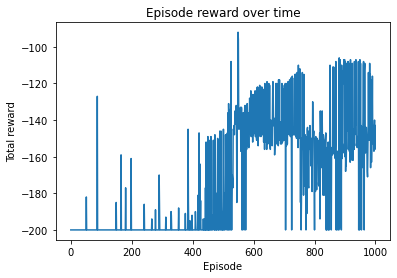

In [11]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()